In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import pandas as pd
import numpy as np
import statsmodels.api as sm
from signal_generator.synthesizer_builder import SynthesizerBuilder
from models.model_factory import ModelFactory

/opt/anaconda3/bin/python


## TODO

- Simulate cosine waves to simulate different frequencies (hear rate and high frequency)
- Add random outliers (spikes) into random places in the signal 
- Add random noise into the signal
- Simulate the confounds
- How to simulate rotation
- Have functionality to render real data
- Could an autoencoder return the beta values? (many cosine waves with one parameter and a bottleneck of 1)
- Read more about syntheitc MRI signal generation
- Evaluate the optimizer and learning rate impacts
- Look into simulating multiple regions
- Think about how RNN could be used to learn the beta values (Could use a Recurrent CNN approach)

## Subject level GLM

In [2]:
# Baseline
# design_matrix = np.array([[ 1.00000000e+00,  0.00000000e+00,  9.07125285e-06,  4.67507768e-02],
#        [ 1.00000000e+00,  2.56410256e-01,  1.62184895e-05, -2.76890343e-02],
#        [ 1.00000000e+00,  5.12820513e-01,  2.74377012e-05, -2.44305850e-02],
#        [ 1.00000000e+00,  7.69230769e-01,  4.43304645e-05, -3.40362688e-03],
#        [ 1.00000000e+00,  1.02564103e+00,  6.88820865e-05,  8.40130664e-03],
#        [ 1.00000000e+00,  1.28205128e+00,  1.03489204e-04, -1.19617571e-02],
#        [ 1.00000000e+00,  1.53846154e+00,  1.50978958e-04,  1.42894120e-02],
#        [ 1.00000000e+00,  1.79487179e+00,  2.14620619e-04,  1.69790383e-02],
#        [ 1.00000000e+00,  2.05128205e+00,  2.98130484e-04,  7.58858876e-02],
#        [ 1.00000000e+00,  2.30769231e+00,  4.05670802e-04,  7.17081155e-02],
#        [ 1.00000000e+00,  2.56410256e+00,  5.41843416e-04,  1.13924093e-03],
#        [ 1.00000000e+00,  2.82051282e+00,  7.11678783e-04, -3.35078702e-02],
#        [ 1.00000000e+00,  3.07692308e+00,  9.20620952e-04, -4.47798884e-03],
#        [ 1.00000000e+00,  3.33333333e+00,  1.17450906e-03, -3.83506800e-02],
#        [ 1.00000000e+00,  3.58974359e+00,  1.47955587e-03, -5.67304245e-02],
#        [ 1.00000000e+00,  3.84615385e+00,  1.84232372e-03, -1.52736904e-01],
#        [ 1.00000000e+00,  4.10256410e+00,  2.26969848e-03, -4.54350655e-02],
#        [ 1.00000000e+00,  4.35897436e+00,  2.76886173e-03,  2.64821959e-02],
#        [ 1.00000000e+00,  4.61538462e+00,  3.34726162e-03,  5.29740884e-02],
#        [ 1.00000000e+00,  4.87179487e+00,  4.01258270e-03, -3.35900639e-02],
#        [ 1.00000000e+00,  5.12820513e+00,  4.77271503e-03, -1.00783236e-02],
#        [ 1.00000000e+00,  5.38461538e+00,  5.63572279e-03,  1.07335678e-01],
#        [ 1.00000000e+00,  5.64102564e+00,  6.60981270e-03, -1.74762378e-02],
#        [ 1.00000000e+00,  5.89743590e+00,  7.70330244e-03,  5.67315325e-02],
#        [ 1.00000000e+00,  6.15384615e+00,  8.92458922e-03,  2.73409977e-02],
#        [ 1.00000000e+00,  6.41025641e+00,  1.02821187e-02, -4.82420946e-02],
#        [ 1.00000000e+00,  6.66666667e+00,  1.17843546e-02,  5.69996052e-02],
#        [ 1.00000000e+00,  6.92307692e+00,  1.34397484e-02,  2.41827730e-02],
#        [ 1.00000000e+00,  7.17948718e+00,  1.52567109e-02, -4.30647624e-02],
#        [ 1.00000000e+00,  7.43589744e+00,  1.72435833e-02,  8.23359079e-03],
#        [ 1.00000000e+00,  7.69230769e+00,  1.94086104e-02, -2.62073996e-02],
#        [ 1.00000000e+00,  7.94871795e+00,  1.83686201e-02,  5.97903404e-03],
#        [ 1.00000000e+00,  8.20512821e+00,  1.71743687e-02,  5.81206115e-02],
#        [ 1.00000000e+00,  8.46153846e+00,  1.58100953e-02, -5.79510790e-02],
#        [ 1.00000000e+00,  8.71794872e+00,  1.42591893e-02,  5.50934857e-02],
#        [ 1.00000000e+00,  8.97435897e+00,  1.25041994e-02, -3.03788855e-02],
#        [ 1.00000000e+00,  9.23076923e+00,  1.05268452e-02,  2.03694016e-03],
#        [ 1.00000000e+00,  9.48717949e+00,  8.30803063e-03,  2.48877705e-02],
#        [ 1.00000000e+00,  9.74358974e+00,  5.82786109e-03,  8.78237695e-03],
#        [ 1.00000000e+00,  1.00000000e+01,  3.06566201e-03,  2.62156648e-02]])

# Noisy Design Matrix
design_matrix = np.array([[ 1.00000000e+00,  0.00000000e+00,  9.07125285e-06,  9.80364192e-03],
       [ 1.00000000e+00,  2.56410256e-01,  1.62184895e-05,  2.14882618e-01],
       [ 1.00000000e+00,  5.12820513e-01,  2.74377012e-05, -1.16218342e-01],
       [ 1.00000000e+00,  7.69230769e-01,  4.43304645e-05, -1.35166679e-01],
       [ 1.00000000e+00,  1.02564103e+00,  6.88820865e-05, -3.31156309e-03],
       [ 1.00000000e+00,  1.28205128e+00,  1.03489204e-04, -3.59697348e-01],
       [ 1.00000000e+00,  1.53846154e+00,  1.50978958e-04, -5.82338266e-02],
       [ 1.00000000e+00,  1.79487179e+00,  2.14620619e-04,  3.95926490e-01],
       [ 1.00000000e+00,  2.05128205e+00,  2.98130484e-04, -1.19023289e-01],
       [ 1.00000000e+00,  2.30769231e+00,  4.05670802e-04,  1.28218510e-01],
       [ 1.00000000e+00,  2.56410256e+00,  5.41843416e-04,  2.77085965e-01],
       [ 1.00000000e+00,  2.82051282e+00,  7.11678783e-04, -2.25577002e-01],
       [ 1.00000000e+00,  3.07692308e+00,  9.20620952e-04, -2.98853350e-01],
       [ 1.00000000e+00,  3.33333333e+00,  1.17450906e-03, -2.29277796e-01],
       [ 1.00000000e+00,  3.58974359e+00,  1.47955587e-03, -2.09512103e-02],
       [ 1.00000000e+00,  3.84615385e+00,  1.84232372e-03, -8.58695272e-02],
       [ 1.00000000e+00,  4.10256410e+00,  2.26969848e-03, -6.64428050e-02],
       [ 1.00000000e+00,  4.35897436e+00,  2.76886173e-03,  3.11571310e-02],
       [ 1.00000000e+00,  4.61538462e+00,  3.34726162e-03,  1.12554137e-01],
       [ 1.00000000e+00,  4.87179487e+00,  4.01258270e-03, -3.76123778e-01],
       [ 1.00000000e+00,  5.12820513e+00,  4.77271503e-03, -5.13667212e-01],
       [ 1.00000000e+00,  5.38461538e+00,  5.63572279e-03, -2.10386760e-01],
       [ 1.00000000e+00,  5.64102564e+00,  6.60981270e-03, -1.74099802e-01],
       [ 1.00000000e+00,  5.89743590e+00,  7.70330244e-03,  3.22965215e-02],
       [ 1.00000000e+00,  6.15384615e+00,  8.92458922e-03,  2.82319126e-01],
       [ 1.00000000e+00,  6.41025641e+00,  1.02821187e-02, -3.88299385e-01],
       [ 1.00000000e+00,  6.66666667e+00,  1.17843546e-02, -4.57326824e-02],
       [ 1.00000000e+00,  6.92307692e+00,  1.34397484e-02, -5.07181830e-02],
       [ 1.00000000e+00,  7.17948718e+00,  1.52567109e-02,  9.64526228e-02],
       [ 1.00000000e+00,  7.43589744e+00,  1.72435833e-02,  7.07497272e-02],
       [ 1.00000000e+00,  7.69230769e+00,  1.94086104e-02, -5.15144083e-01],
       [ 1.00000000e+00,  7.94871795e+00,  1.83686201e-02, -1.68272056e-01],
       [ 1.00000000e+00,  8.20512821e+00,  1.71743687e-02,  5.01083998e-02],
       [ 1.00000000e+00,  8.46153846e+00,  1.58100953e-02,  2.09052795e-01],
       [ 1.00000000e+00,  8.71794872e+00,  1.42591893e-02, -1.42146267e-01],
       [ 1.00000000e+00,  8.97435897e+00,  1.25041994e-02, -7.19001300e-02],
       [ 1.00000000e+00,  9.23076923e+00,  1.05268452e-02, -3.76992774e-01],
       [ 1.00000000e+00,  9.48717949e+00,  8.30803063e-03, -1.16162456e-01],
       [ 1.00000000e+00,  9.74358974e+00,  5.82786109e-03, -1.90408205e-01],
       [ 1.00000000e+00,  1.00000000e+01,  3.06566201e-03,  4.71441206e-02]])
print(design_matrix.shape)
beta_values_target = np.array([1, 2, 20, 0])
# print(design_matrix.shape, beta_values.shape)
y_true = np.dot(design_matrix, beta_values_target)
print("Y_true: ", y_true, type(y_true), y_true.shape)

(40, 4)
Y_true:  [ 1.00018143  1.51314488  2.02618978  2.53934815  3.0526597   3.56617234
  4.07994266  4.59403599  5.10852671  5.62349804  6.13904199  6.65525922
  7.17225858  7.69015684  8.2090783   8.72915417  9.25052217  9.77332595
 10.29771447 10.82384139 11.35186456 11.88194522 12.41424753 12.94893785
 13.48618408 14.02615519 14.56902043 15.11494881 15.66410858 16.21666655
 16.77278759 17.2648083  17.75374379 18.23927883 18.72108123 19.19880193
 19.67207536 20.14051959 20.6037367  21.06131324] <class 'numpy.ndarray'> (40,)


## Synthesize Brain Data

Task signal shape:  (315,)
Task signal shape:  (420,)
Signal shape:  (500, 2)
Design matrix:  (500, 4)


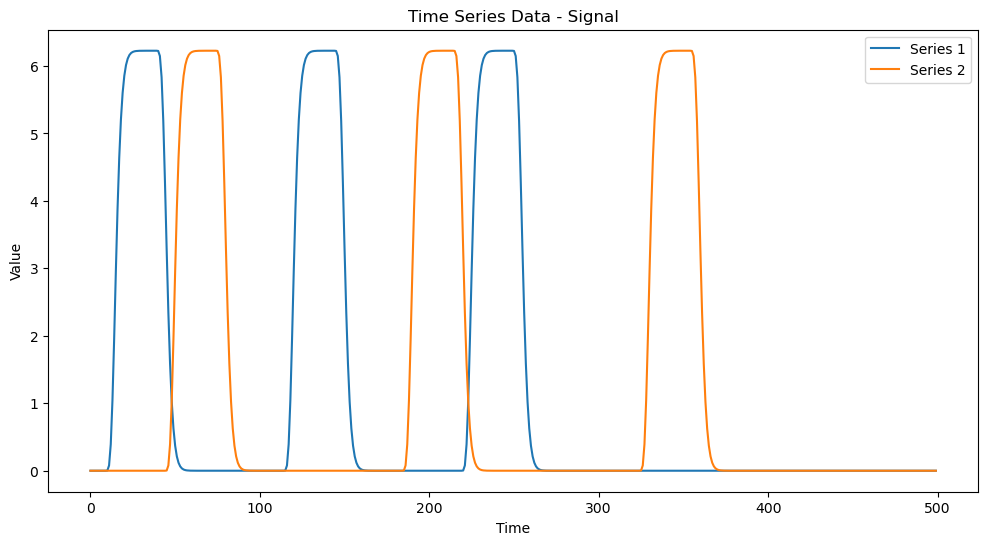

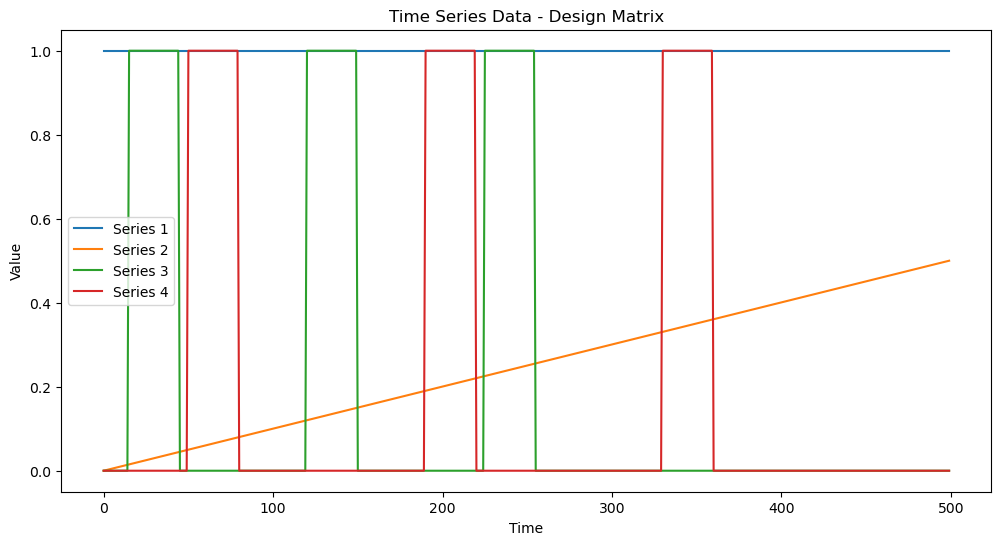

Y_true:  [ 1.          1.00150301  1.00300601  1.00450902  1.00601202  1.00751503
  1.00901804  1.01052104  1.01202405  1.01352705  1.01503006  1.01653307
  1.01803607  1.01953908  1.02104208 13.02254509 13.0240481  13.0255511
 13.02705411 13.02855711 13.03006012 13.03156313 13.03306613 13.03456914
 13.03607214 13.03757515 13.03907816 13.04058116 13.04208417 13.04358717
 13.04509018 13.04659319 13.04809619 13.0495992  13.0511022  13.05260521
 13.05410822 13.05561122 13.05711423 13.05861723 13.06012024 13.06162325
 13.06312625 13.06462926 13.06613226  1.06763527  1.06913828  1.07064128
  1.07214429  1.07364729  4.0751503   4.07665331  4.07815631  4.07965932
  4.08116232  4.08266533  4.08416834  4.08567134  4.08717435  4.08867735
  4.09018036  4.09168337  4.09318637  4.09468938  4.09619238  4.09769539
  4.0991984   4.1007014   4.10220441  4.10370741  4.10521042  4.10671343
  4.10821643  4.10971944  4.11122244  4.11272545  4.11422846  4.11573146
  4.11723447  4.11873747  1.12024048  1.121

In [3]:
%reload_ext autoreload
# Create a Synthesizer with custom parameters using the builder
synth_builder = SynthesizerBuilder()
synth = (synth_builder
       .add_length(500)
       .add_intercept()
       .add_drift(0, 0.5)
       .add_signal(30, 60, 3, 15, "1")
       .add_signal(30, 60, 3, 50, "2")
       .build())
signal, design_matrix = synth.get()
print("Signal shape: ", signal.shape)
print("Design matrix: ", design_matrix.shape)
synth.plot_signal()
synth.plot_design_matrix()

# Get the GLM Values
beta_values_target = np.array([1, 1.5, 12, 3])
# print(design_matrix.shape, beta_values.shape)
y_true = np.dot(design_matrix, beta_values_target)
print("Y_true: ", y_true, type(y_true), y_true.shape)

## Deep learning implementation

### Simple matrix multiplication version

In [4]:
# Use Factory pattern to get models
BoldGLM = ModelFactory.create_model('glm', design_matrix)

# Run the model
print(signal.shape)
# TODO - DESIGN MATRIX SHAPE SHOULD BE (400, 1)
# model, losses = BoldGLM.train_bold_glm(design_matrix, y_true)
model, losses = BoldGLM.train_model(design_matrix, signal[:, 1])

beta_values = model.get_betas()
print("Target: ", beta_values_target)
print("Learned: ", beta_values.flatten())

(500, 2)
Epoch [1/20000], Loss: 3.2203
Converged at epoch 317 with loss: 0.2593
Target:  [ 1.   1.5 12.   3. ]
Learned:  [ 0.22111298 -0.3400508  -0.1660055   5.6356344 ]


### Recurrent CNN Version

In [5]:
# Import the model
SeqCNN = ModelFactory.create_model('cnn', design_matrix)

# Run the model
print(signal.shape)
model, losses = SeqCNN.train_model(design_matrix, signal[:, 1])
# model, losses = BoldGLM.train_bold_glm(design_matrix, signal)

beta_values = model.get_betas()
print("Target: ", beta_values_target)
print("Learned: ", beta_values.flatten())

data_shape:  [[1.         0.         0.         0.        ]
 [1.         0.001002   0.         0.        ]
 [1.         0.00200401 0.         0.        ]
 ...
 [1.         0.49799599 0.         0.        ]
 [1.         0.498998   0.         0.        ]
 [1.         0.5        0.         0.        ]]
(500, 2)
Target:  [ 1.   1.5 12.   3. ]
Learned:  tensor([ 1.4988,  1.2499,  0.5854, -4.0336], grad_fn=<ViewBackward0>)


## Autoencoder Version

In [6]:
print(design_matrix.shape)
VAE = ModelFactory.create_model('autoencoder', design_matrix)

model = VAE.train(design_matrix, 0.001, 2000)

beta_values = model.get_latent_value()
print("Learned latent value: ", beta_values_target)

(500, 4)
Data type init:  <class 'numpy.ndarray'>
Data type init:  <class 'torch.Tensor'>


TypeError: AutoEncoder.train() missing 1 required positional argument: 'x'

## Prebuilt GLM

In [ ]:
# Define and fit the GLM model
model = sm.GLM(signal[:, 1], design_matrix, family=sm.families.Gaussian())
results = model.fit()

# Output the summary of the model
print(results.summary())
print("Beta values: ", results.params)